**Find the smallest sphere that encloses a set of** $k$ **points** $p_i \in R^n$. 

We will consider $n=2$ for sake of simplicity and to allow easy visualization. Our input data will be generate randomly around the origin with a standard normal distibution.

Here it is:

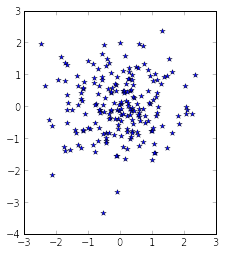

In [12]:
%matplotlib inline
import numpy as np
import plot as mskplt

n = 2
k = 200

p=  np.random.normal(size=(k,n))

mskplt.plot_points(p)


The natural formulation is 

\begin{equation}
  \begin{aligned}
\min \max_{i=1,\dots,k} \| p_i - p_0\|_2 \\
  \end{aligned}
\end{equation}

The maximum in the objective function can be easily, i.e.

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& r_i \geq \| p_i - p_0\|_2 ,& \quad & i=1,\ldots,k\\
\end{aligned}
\end{equation}

The SOCP formulation reads

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& (r_0,p_i - p_0) \in Q^{(n+1)}, & \quad & i=1,\ldots,k.
\end{aligned}
\end{equation}

Note that we do not need to take the square of the distance. 


The `fusion` implementatin starts defining the optimization model:

In [21]:
from mosek.fusion import *

M = Model("minimal sphere enclosing a set of points")


Note that we have organized our data by row, i.e. each point is a row vector.

The next step is two define the problem variables:

In [14]:
r0 = M.variable("r_0", 1         , Domain.greaterThan(0.))
p0 = M.variable("p_0", NDSet(1,n), Domain.unbounded())

Before defining the constraints, we note that we can write


\begin{equation}
r = \left(r_0,\ldots,r_0\right)^T \in \mathbb{R}^k
\end{equation}

and 

\begin{equation}
P = \left(p_0,\ldots,p_k\right)^T \in \mathbb{R}^{k\times n}.
\end{equation}

so that 

\begin{equation}
(r_0,p_i - p_0) \in Q^{(n+1)},  \quad  i=1,\ldots,k.
\end{equation}

can be compactly expressed as 

\begin{equation}
(r,P) \in \Pi Q^{(n+1)}.
\end{equation}

This formulation allows to use a single call to Fusion:


In [15]:
ee = Expr.hstack( Variable.repeat(r0,k),Expr.sub( Variable.repeat(p0,k), DenseMatrix(p) ) )

M.constraint(ee, Domain.inQCone())


output = open('logp','wt')
M.setLogHandler(output)


M.objective(ObjectiveSense.Minimize, r0)

M.solve()

rstar= r0.level()[0]
pstar= p0.level()
 
print("r*= %f" % rstar)
print("p*= ", pstar)
    

r*= 3.100683
('p*= ', [-0.28568222616490296, -0.27083257284266893])


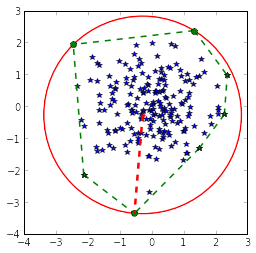

In [17]:
mskplt.plot_points(p,pstar,rstar)

In [18]:
!cat logp

Computer
  Platform               : Linux/64-X86    
  Cores                  : 2               

Problem
  Name                   : minimal sphere enclosing a set of points
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 600             
  Cones                  : 200             
  Scalar variables       : 603             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Conic interior-point optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Eliminator - elim's                 : 0               
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Optimiz

= Dual Formulation 

Let's derive the dual:

\begin{aligned}
    \max & \sum_i b_i^T y_i \\
    & \sum_i y_i = c \\
    & y_i \in \mathcal{Q}^{n+1}
\end{aligned}


where $c=\left(1, 0_n\right)^T$ and $b_i=(0,p_i)$. Introducing 

\begin{equation}
 Y = \left[ y_0, \ldots,y_k  \right], B=\left[ b_1,\ldots,b_k\right]
\end{equation}


\begin{aligned}
    \max & \left< B, Y \right> \\
    & Y \mathbb{1}_k = c \\
    & Y_{:,i} \in \mathcal{Q}^{n+1}
\end{aligned}



In [19]:
Md = Model()

y= Md.variable(NDSet(k,n+1), Domain.inQCone(k,n+1))
Md.constraint( Expr.mul( [1.0 for i in range(k)], y), Domain.equalsTo( [1.] + [0. for i in range(n)]) )
    
Md.objective(ObjectiveSense.Maximize, Expr.dot( DenseMatrix(p.tolist()), y.slice([0,1],[k,n+1])) )
 
outputd = open('logd','wt')
Md.setLogHandler(outputd)

Md.solve()


Let's take a closer look to the solver output:

In [20]:
!cat logd

Computer
  Platform               : Linux/64-X86    
  Cores                  : 2               

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3               
  Cones                  : 200             
  Scalar variables       : 600             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Conic interior-point optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Eliminator - elim's                 : 0               
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Optimizer  - threads           

The important point is the the flop and the dense dimensions

In [10]:
!grep flop log*

logd:Factor     - dense dim.             : 0                 flops                  : 2.63e+03        
logp:Factor     - dense dim.             : 2                 flops                  : 4.21e+06        


7.461538461538462

In [7]:
!grep "Optimizer terminated" log*

logd:Optimizer terminated. Time: 0.01    
logp:Optimizer terminated. Time: 0.06    


In [9]:
0.06/0.01


6.0